# 1. Giriş

Tek değişkenli bir zaman serisi verileri yalnızca tek bir zamana bağlı değişken içerirken, çok değişkenli bir zaman serisi verileri birden çok zamana bağlı değişkenden oluşur. Değişkenler arasındaki ilginç karşılıklı bağımlılıkları ve ortak hareketleri modellemek ve açıklamak için genellikle çok değişkenli zaman serisi analizini kullanırız. Çok değişkenli analizde - varsayım, zamana bağlı değişkenlerin yalnızca geçmiş değerlerine bağlı olmadığı, aynı zamanda aralarında bağımlılık da gösterdiğidir. Çok değişkenli zaman serisi modelleri, belirli bir veri için daha güvenilir ve doğru tahminler sağlamak için bağımlılıklardan yararlanır, ancak tek değişkenli analiz genel olarak çok değişkenliden daha iyi performans gösterir.

Burada **vektör özbağlanım modelleri'ni (vector autoregression model-VAR)** inceleyeceğiz. VAR modeli eşanlı denklem sistemlerine benzer. Eşanlı denklem sistemlerinde bazı değişkenler modeldeki diğer değişkenler tarafından açıklanırken, bazıları da sadece açıklayıcı değişken görevini üstlenirler ve açıklayıcı değişkenlerin değerleri önceden belirlenmiştir. Fakat Sims(1980); değişkenler arasında gerçekten bir eşanlılık söz konusuysa içsel ve dışsal değişkenler arasında bir ayrım yapılmaması gerektiğini söylemiş ve buradan hareketle VAR modelini ileri sürmüştür. VAR modelde değişkenlerin tümü içseldir. Bu özelliği dolayısıyla VAR modelleri eşanlı denklem sistemlerinden ayrılmaktadır.

# 2. Vektör Özbağlanım Modelinin Genel Gösterimi

VAR'ın özelliği, tekdeğişkenli özbağlanım modelini birden çok zaman serisi içeren bir seriler yöneyine genellemesidir. $k$ değişkenli bir VAR modelinde herbir değişkenin sırayla bağımlı değişken olduğu $k$ sayıda denklem olur. Her bir denklemdeki gecikme sayısı da p'ye eşittir. $k$ değişkenli ve $p$ gecikmeli böyle bir denklem sistemine $\operatorname{VAR}(p)$ denir ve aşağıdaki şekilde gösterilir:

\begin{aligned}
&Y_{1 t}=\alpha_{10}+\sum_{j=1}^{p} \beta_{1 p} Y_{1 t-p}+\ldots+\sum_{j=1}^{p} \lambda_{1 p} Y_{k t-p}+u_{1 t}\\
&\vdots \quad \vdots \quad \vdots \quad \vdots \quad \vdots \quad \vdots \quad \vdots \quad \vdots \quad \vdots \quad \vdots \quad \vdots\\
&Y_{k t}=\alpha_{k 0}+\sum_{j=1}^{p} \beta_{k p} Y_{1 t-p}+\ldots+\sum_{j=1}^{p} \lambda_{k p} Y_{k t-p}+u_{k t}
\end{aligned}

Bu yazıda, Türkiye için 2000-Q1:2021-Q3 dönemi için özel nihai tüketim harcamaları, devlet nihai tüketim harcamaları ve GSYH verilerinin logartimik dönüşümlü biçimlerini kullanacağız.

In [1]:
import pandas_datareader as pdr
import datetime
import pandas as pd
import numpy as np


# başlangıç ve bitiş tarihleri
başlangıç = datetime.datetime(2000, 1, 1)
bitiş    = datetime.datetime(2021, 9, 1)

# makro iktisadi değişkenler
özel_nihai_tüketim = pdr.DataReader('TURPFCEQDSMEI', 'fred', start=başlangıç, end=bitiş).rename(columns = {"TURPFCEQDSMEI":'özel_nihai_tüketim'})
devlet_nihahi_tüketim = pdr.DataReader('TURGFCEQDSMEI', 'fred', start=başlangıç, end=bitiş).rename(columns = {"TURGFCEQDSMEI":'devlet_nihai_tüketim'})
gsyh      = pdr.DataReader('TURGDPNQDSMEI', 'fred', start=başlangıç, end=bitiş).rename(columns = {"TURGDPNQDSMEI":'gsyh'})

# reel gsyh ve tüketim harcamaları için logaritmik dönüşüm
gsyh['log_gsyh'] = np.log(gsyh['gsyh'])
özel_nihai_tüketim['log_özel_tüketim'] = np.log(özel_nihai_tüketim['özel_nihai_tüketim'])
devlet_nihahi_tüketim['log_devlet_tüketim'] = np.log(devlet_nihahi_tüketim['devlet_nihai_tüketim'])

# veri çerçevelerinin birleştirilmesi
makro_veri = gsyh[['log_gsyh']].merge(
    özel_nihai_tüketim[['log_özel_tüketim']],
    left_index=True,
    right_index=True
).merge(
    devlet_nihahi_tüketim[['log_devlet_tüketim']],
    left_index=True,
    right_index=True
)

Verinin görünümüne bakalım:

In [2]:
print(makro_veri.head())

             log_gsyh  log_özel_tüketim  log_devlet_tüketim
DATE                                                       
2000-01-01  24.361417         23.996256           22.218192
2000-04-01  24.446563         24.037710           22.323838
2000-07-01  24.518549         24.115512           22.401991
2000-10-01  24.585704         24.162953           22.460808
2001-01-01  24.658585         24.233973           22.509961


Verilerin grafiğini çizelim:

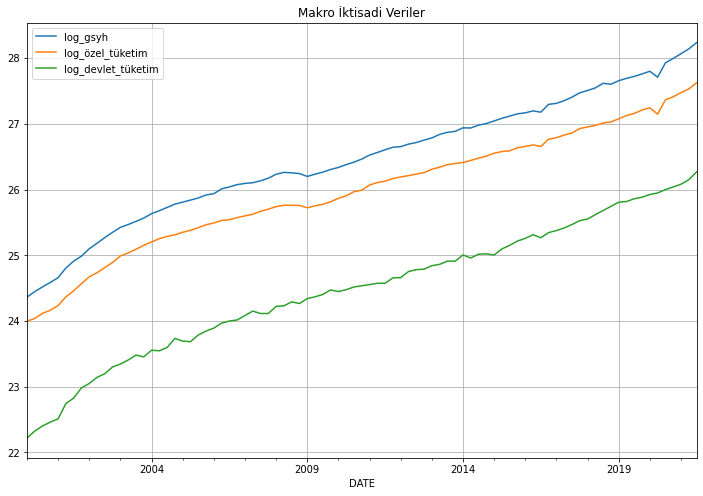

In [3]:
import matplotlib.pyplot as plt

makro_veri.plot(figsize=(12,8))
plt.title("Makro İktisadi Veriler")
plt.grid()

# 3. VAR Modeli Uygulaması

VAR modellerinde durağanlık çok önemlidir. Çünkü VAR modelleri de durağan serilerle çalışmaktadır. Durağanlığın açıklanmasına geçilmeden önce dikkat edilmesi gereken noktalar bulunmaktadır. VAR modellerinin eşanlı denklem sistemleriyle benzer olduğu belirtilmiştir. Ancak VAR modelleri, modelde yer alan bağımsız değişkenler arasında şimdiki değerleri içermemesi sebebiyle eşanlı denklem sistemlerinden ayrılmaktadır. 

Bu yazıda değişkenlerin durağanlığıyla birlikte gerçekleştireceğimiz diğer istatistiksel testler için hazırladığımız Python betiğine [buradan](https://gist.github.com/homodigitus/16120b29bcc52a85e37611a417400fd7) erişebilirsiniz. 

## 3.1. Durağanlık Testi: Genişletilmiş Dickey-Fuller Testi

Durağanlık kavramına önceki yazılarımızda değinmiş, durağanlığın olmadığı durumlarda ortaya çıkabilecek durumları tartışmıştık. Bununla birlikte VAR modelleri için de farklı yaklaşımlar sözkonusudur. Pagan (1987)’ye göre VAR modeli için öncelikle zaman serilerinin durağan olması gerekmektedir. Fakat durağanlığı sağlamak amacıyla fark alımının bilgi kaybına sebep olması tartışma konusudur. Sims (1980) ve Doan (1992) birim kökün var olması durumunda dahi fark alınmasına karşı görüş belirtmişler ve VAR analizinin amacının parametre tahmini değil, değişkenler arası ilişkilerin belirlenmesi olduğunu söylemişlerdir. İlk olarak verilerimizin durağanlık sınamalarını gerçekleştireceğiz:

In [4]:
import pandas as pd
import numpy as np
from var_model import adf_test, granger_causality_matrix, cointegration_test

In [5]:
sonuçlar = adf_test(makro_veri, trend='ct', max_lags=4, method='aic')
sonuçlar

Seriler seviyelerinde durağan değildir. Dolayısıyla serilerin birinci farkını alıp durağan hale gelip gelmediklerine bakalım:

In [6]:
makro_veri_farkı_alınmış = makro_veri.diff().dropna()
sonuçlar = adf_test(makro_veri_farkı_alınmış, trend='ct', max_lags=4, method='aic')
sonuçlar

Böylece, tüm değişkenlerimiz birinci farkında durağan hale gelmiştir.

## 3.2. Eş Bütünleşme (Cointegration) Testleri

Düzeyde durağan olmayan zaman serilerinin uzun dönemde birlikte hareket edip etmediklerini araştıran koentegrasyon analizine göre, durağan olmayan seriler koentegre ise, bu değişkenlerin farklarının alınması pek uygun olmayacaktır. Değişkenlerin birlikte hareket eden bir trende sahip olmaları dolayısıyla, farklarının alınması bu ortak trendi ortadan kaldıracaktır. Buna bağlı olarak koentegre olan ve diğer bir ifade ile uzun dönemde birlikte hareket eden serilerin düzey değerleriyle yapılan analizlerde sahte regresyon söz konusu olmayacaktır. Engel-Granger (1987) tarafından ileri sürülen Engel-Granger iki aşamalı koentegrasyon testi ve daha sonra Johansen (1988) ve Johansen-Juselius (1990) tarafından geliştirilen koentegrasyon testleri, durağan olmayan zaman serilerinin aynı düzeyde farkları alındığında durağanlıklarının sağlanmasını gerektirmektedir.

### 3.2.1. Engle-Granger Eş Bütünleşme Testi

İki aşamalı Engel-Granger yöntemine göre, birinci aşamada En Küçük Kareler (OLS) yöntemi yardımıyla model tahmin edilerek hata terimleri elde edilir. İkinci aşamada ise elde edilen hata terimlerine birim kök sınaması yapılır. Sonuçta hata terimleri durağan çıkarsa eş bütünleşme söz konusudur. Hata terimlerinin birim köklü olması ise ele alınan seriler arasında eş bütünleşme ilişkisinin olmadığını göstermektedir. Engel-Granger yöntemi basit uygulanabilir olmasına rağmen 2’den fazla değişken söz konusu olduğunda, değişken sayısıyla birlikte eş bütünleşme sayısı da artacağından dolayı sağlıklı sonuç verememektedir ve farklı normalleştirmelerde sonuçlar değişebilmektedir.

### 3.2.2. Johansen Eş Bütünleşme Testi

Johansen-Juselius çoklu eş bütünleşme yönteminde öncelikle aşağıda ifade edilen vektör otoregresif (VAR) model ele alınmaktadır:

$$
X_{t}=\pi_{1} X_{t-1}+\pi_{2} X_{t-2}+\ldots . .+\pi_{k} X_{t-k}+\mu+e_{t}
$$

Durağan olmayan X değişkenlerinin 1. farklar1 alındığında ise, hata düzeltme formundaki;

$$
\Delta X_{t}=\Gamma_{1} \Delta X_{t-1}+\ldots+\Gamma_{k-1} \Delta X_{t-k+1}+\pi X_{t-k}+\mu+e_{t}
$$

süreci elde edilmektedir. Burada,

$$
\begin{aligned}
&\Gamma_{i}=-I+\pi_{1}+\ldots+\pi_{i} \\
&\pi=I-\pi_{1}-\ldots-\pi_{k} \quad t=1 \ldots . t
\end{aligned}
$$

ile ifade edilmektedir. Modelde; $\quad X_{t} \quad I(1)$ 'de bütünleşik olan değişkenlerin $(p \times 1)$ boyutlu vektörü, $e_{t}$ hata terimi, $\Gamma_{i}(p \times p)$ boyutlu parametreler matrisidir. $\pi$ ise değişkenlerin uzun dönem ilişkileri hakkinda bilgi veren, $\Gamma_{i}$ ile aynı boyutta $(p \times p)$ boyutlu bir matristir. $\pi$ matrisinin rank1; değişkenlerin doğrusal şekilde bağımsız ve durağan doğrusal kombinasyon sayısıdır. Matris rankının tam olması, $X_{t}$ 'de yer alan tüm değişkenlerin durağan olduğunu ifade etmektedir. Rankın 0 olması halinde ise, $X_{t}$ 1. farklar formunda bir vektör özbağlanım (VAR) modele dönüşür. Bu, modelde yer alan değişkenler arasında uzun dönem ilişkisi olmadığının bir ifadesidir.

$\pi$ matrisinin rank1 1 yada 1 'den fazla ise, bu durumda 1 yada daha fazla eş bütünleşik vektör söz konusu olacağından bu, uzun dönem ilişkisini ifade edecektir. Çoklu eş bütünleşme analizinde en az l eş bütünleşik vektörün olması beklenmektedir. 1 ve ya daha fazla eş bütünleşik vektör bulunması durumunda eş bütünleşmenin olmadığını söyleyen $H_{0}$ hipotezi reddedilecektir.

Johansen-Juselius (1990); eş bütünleşik vektör sayısını ya da diğer anlamda $\pi$ matrisinin rankını bulmak amacıyla 2 farklı istatistik ileri sürmüştür. İz istatistiği;

$$
\lambda_{\text {Trace }}=-T \cdot \sum_{i=r+1}^{p} \ln \left(1-\lambda_{i}\right)
$$

ve maksimum öz değer istatistiği;

$$
\lambda_{\max }=-T \cdot \ln \left(1-\lambda_{r+1}\right) \quad 0 \leq \mathrm{r} \leq \mathrm{p}
$$

olarak bilinen bu istatistiklerin sonuçları Johansen ve Juselius tarafından önerilen tablo kritik değerleri ile karşılaştırılmaktadır. Johansen testinin kritik değerleri tahmin edilen modele doğrusal trendlerin ve mevsimsel gölge değişkenlerin nasıl ilave edildiğine bağlı olup 3 kısımdan oluşmaktadır. Birincisinde sabit terim modele hiçbir kısıt olmadan ilave edilmiştir. 2. kısımda yine sabit terim modele ilave edilmiştir fakat bu koentegre vektörlere göre kısıtlanmıştır. 3. kısımda ise sabit terim ilave edilmemiştir.

Makro verilerimizin farkı alınmış biçimi için, Johansen eş bütünleşme ilişkilerine bakalım:

In [7]:
cointegration_test(makro_veri_farkı_alınmış)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
log_gsyh ::  54.02     > 24.2761   =>   True
log_özel_tüketim ::  19.93     > 12.3212   =>   True
log_devlet_tüketim ::  3.78      > 4.1296    =>   False


## 3.3. Granger Nedensellik Testi

Vektör özbağlanım modelinin arkasındaki temel, sistemdeki zaman serilerinin her birinin birbirini etkilemesidir. Yani sistemdeki diğer serilerle birlikte kendi geçmiş değerleri ile seriyi tahmin edebiliriz. Granger nedensellik Testini kullanarak, modeli oluşturmadan önce bu ilişkiyi test etmek mümkündür. Aslında, Granger (1969) tarafindan önerilen Granger nedensellik testi klasik anlamda bir nedensellik testinden ziyade bir öngörülebilirlik testidir. Bu kavrama göre $x_{t}$ bașka bir değișkeni, $y_{t}$, öngörmekte bașarilı ise $x y$ 'nin Granger-nedenidir. Daha formel olarak, sadece $x_{t}$ 'nin gecikmeli değerlerini içeren bir modelden hareketle her $s>0$ için hesaplanan $y_{t+s}$ öngörüsünün ortalama hata karesi, hem $x_{t}$ 'nin hem de $y_{t}$ 'nin gecikmeli değerlerini içeren modelden elde edilen öngörü ortalama hata karesi ile aynıysa, $x$ değișkeni $y$ değișkeninin Granger-nedeni değildir. Bașka bir ifadeyle $x$ 'in gecikmeli değerleri $y$ 'yi öngörmekte bașarisızdır.

$x^{\prime}$ in $y$ 'nin Granger-nedeni olmadığını söyleyen boş hipotez:

$$
H_{0}: \phi_{12}^{1}=0, \phi_{12}^{2}=0
$$

birinci denklemden hareketle standart $F$ testiyle sınanabilir. Yeterince büyük bir $F$ istatistigi $x$ değișkeninin $y$ değișkenini öngörmede bașarılı olduğuna, yani Granger-nedeni olduğuna ișaret eder. Granger-nedenselliği $Y_{1}$ ve $Y_{2}$ gibi iki grup değișken arasında da hesaplanabilir. $Y_{2}$ grubunda yer alan değișkenler $Y_{1}$ grubunda yer alan değișkenleri öngörmede bașarısız ise $Y_{2}$ blok dışsaldır (block exogenous). Bu durumda F testi yerine Wald ya da LR testlerinin uygulanması gerekir.

Makro verilerimiz için, nedensellik ilişkilerini görebileceğimiz nedensellik matrisini çıkalarım:

In [8]:
nedensellik_matrisi = granger_causality_matrix(data=makro_veri_farkı_alınmış, 
                                               variables=makro_veri_farkı_alınmış.columns, 
                                               maxlag=4)
nedensellik_matrisi

,log_gsyh_x,log_özel_tüketim_x,log_devlet_tüketim_x
log_gsyh_y,1.0000,0.5559,0.4011
log_özel_tüketim_y,0.3197,1.0000,0.0964
log_devlet_tüketim_y,0.0091,0.0202,1.0000


Nedensellik matrisine göre, gsyh değişkeninin devlet tüketim harcamalarının Granger nedeni olduğunu; özel sektör tüketim harcamalarının devlet tüketim harcamalarının Granger nedeni olduğunu söyleyebiliriz.

## 3.4. VAR Modelinin Kurulması

VAR modeli için `statsmodels` çerçevesinden `VAR` nesnesini kullanacağız. Modeli oluşturmadan önce de, öngörülerin nasıl olduğunu görebilmek için verimizi eğitim ve test verisi olarak böleceğiz

In [9]:
from statsmodels.tsa.api import VAR

gözlem_sayısı = 4
eğitim_verisi, test_verisi = makro_veri_farkı_alınmış[0:-gözlem_sayısı], makro_veri_farkı_alınmış[-gözlem_sayısı:]

# VAR modeli
model = VAR(eğitim_verisi)

C:\Users\GTUSR0319\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


VAR modeli için uygun gecikme sayısı seçimi zor bir problem olabilir. Bunun için, olabilirlik testi (likelihood test) veya bilgi kriterlerine dayalı gecikme sayısı seçiçi kullanılabilir. Bunun için, `select_order` metodunu kullanacağız:

In [10]:
gecikme_sayısı = model.select_order(maxlags=12)
gecikme_sayısı.summary()

,AIC,BIC,FPE,HQIC
0,-21.72,-21.63*,3.679e-10,-21.68
1,-21.87*,-21.48,3.176e-10*,-21.72*
2,-21.72,-21.05,3.700e-10,-21.45
3,-21.66,-20.70,3.937e-10,-21.28
4,-21.57,-20.32,4.347e-10,-21.07
5,-21.41,-19.87,5.173e-10,-20.79
6,-21.38,-19.55,5.386e-10,-20.66
7,-21.33,-19.21,5.818e-10,-20.49
8,-21.27,-18.86,6.402e-10,-20.31
9,-21.12,-18.43,7.724e-10,-20.05


Uygun gecikme sayısını AIC baz alarak 1 olarak belirleyelim ve modeli oluşturalım:

In [11]:
sonuçlar = model.fit(maxlags=1, ic='aic')

Model çıktısına da bakalım:

In [12]:
sonuçlar.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Jan, 2022
Time:                     12:18:15
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -20.9570
Nobs:                     81.0000    HQIC:                  -21.1694
Log likelihood:           530.324    FPE:                5.55300e-10
AIC:                     -21.3118    Det(Omega_mle):     4.80536e-10
--------------------------------------------------------------------
Results for equation log_gsyh
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.038849         0.007305            5.318           0.000
L1.log_gsyh                  -0.161084         0.294664           -0.547           0.585
L1.log_özel_tüketim      

## 3.5. Hataların Dizisel İlişkisinin Kontrol Edilmesi

Hatalarda (errors) herhangi bir artık model olup olmadığını kontrol etmek için hataların dizisel ilişkisi (serial correlation) kullanılır. Bu bizim için ne anlama geliyor? Hatalarda herhangi bir ilişki varsa, o zaman, zaman serilerinde hala model tarafından açıklanmaya bırakılan bir şeyler vardır. Bu durumda, yapılacak olan ya modelin gecikme sayısını arttırmak ya da sisteme daha fazla tahmin edici dahil etmek ya da zaman serisini modellemek için farklı bir algoritma aramaktır. Bu nedenle, dizisel ilişkiyi kontrol etmek, modelin zaman serilerindeki varyansları ve kalıpları yeterince açıklayabildiğinden emin olmaktır. Hataların dizisel ilişkisini kontrol etmenin yaygın bir yolu, Durbin-Watson test istatistiği kullanmaktır:

$$
D W=\frac{\sum_{t=2}^{T}\left(\left(e_{t}-e_{t-1}\right)^{2}\right)}{\Sigma_{t=1}^{T} e_{t}^{2}}
$$

Bu istatistiğin değeri 0 ile 4 arasında değişebilir. 2 değerine ne kadar yakınsa, anlamlı bir dizisel ilişki yoktur. 0'a ne kadar yakınsa pozitif bir dizisel ilşki vardır ve 4'e ne kadar yakınsa negatif dizisel ilişki vardır anlamına gelir.

In [13]:
from statsmodels.stats.stattools import durbin_watson

hata_kontrolü = durbin_watson(sonuçlar.resid)

for col, val in zip(eğitim_verisi.columns, hata_kontrolü):
    print(col, ':', round(val, 2))

log_gsyh : 1.79
log_özel_tüketim : 1.78
log_devlet_tüketim : 2.09


Dizisel ilişki olmadığını yaklaşık olarak söyleyebiliriz.

## 3.6. Öngörü

Doğrusal tahminci, ortalama kare hatası açısından en uygun h-adımlı öngörüdür:

$$
y_{t}(h)=\nu+A_{1} y_{t}(h-1)+\cdots+A_{p} y_{t}(h-p)
$$

Bu öngörüleri üretmek için `forecast` metodunu kullanabiliriz. Öngörü için "ilk değeri (initial value)" belirtmemiz gerekir:

In [14]:
gecikme_sayısı = sonuçlar.k_ar
sonuçlar.forecast(test_verisi.values[-gecikme_sayısı:], 4)

array([[0.05016013, 0.0488857 , 0.04938092],
       [0.0433173 , 0.04100672, 0.04838135],
       [0.04321125, 0.04131548, 0.0456009 ],
       [0.04294585, 0.0408638 , 0.04633208]])

`forecast_interval` metodu, asimptotik standart hatalarla birlikte yukarıdaki öngörüleri üretecektir. Bunlar, `plot_forecast` metodu kullanılarak görselleştirilebilir:

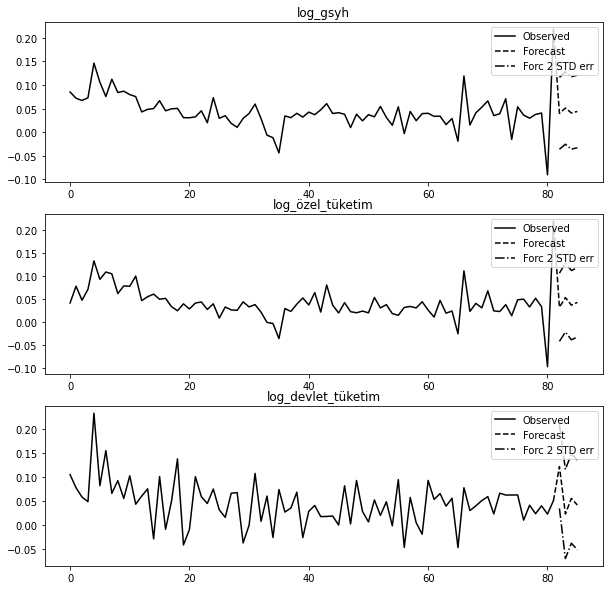

In [15]:
sonuçlar.plot_forecast(4);

## 3.7. Etki-Tepki Analizi (Impulse Response Analysis)

VAR analizi ile, hata terimleri üzerinde değişkenlerin beklenmedik şoklarının ortaya çıkarılması bu yöntemin önemli bir özelliğidir. Etki tepki fonksiyonları, sistemde yer alan değişkenlere birer birimlik şok uygulandığında diğer değişkenlerin gösterdikleri tepkiyi göstermektedir. Buna bağlı olarak ilgili değişkenler üzerinde en etkili değişkenin bir politika aracı olarak kullanılıp kullanılamayacağı ortaya koyulmaktadır. Uygulamada, $VAR(p)$ sürecinin $\mathrm{MA}(\infty)$ temsili kullanılarak hesaplanır:

$$
Y_{t}=\mu+\sum_{i=0}^{\infty} \Phi_{i} u_{t-i}
$$

Etki-tepki analizini `irf` metodu ile gerçekleştirebiliriz:

In [16]:
etki_tepki = sonuçlar.irf(4)

Bunlar, ortogonalize edilmiş veya ortogonalize edilmemiş biçimde, `plot` metodu kullanılarak görselleştirilebilir. Asimptotik standart hatalar, varsayılan olarak, kullanıcı tarafından değiştirilebilen %95 önem düzeyinde çizilir.

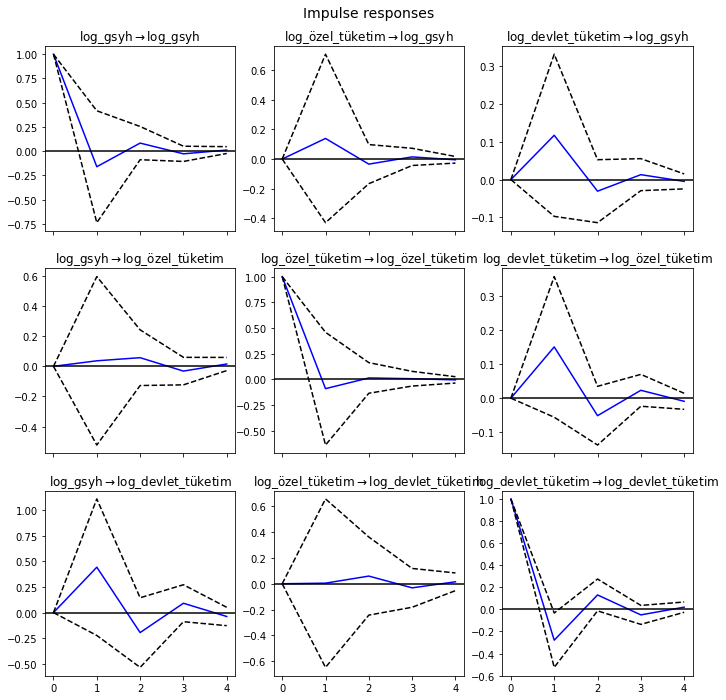

In [17]:
etki_tepki.plot(orth=False);

Bu çıktı şöyle yorumlanabilir: örneğin, özel tüketim harcamalarındaki şokun gsyh üzerindeki etkisi bir dönem sonra geçmektedir diyebiliriz.

$\Psi_{n}=\sum_{i=0}^{n} \Phi_{i}$ kümülatif etkileri, uzun dönem etkilerle birlikte çizilebilir:

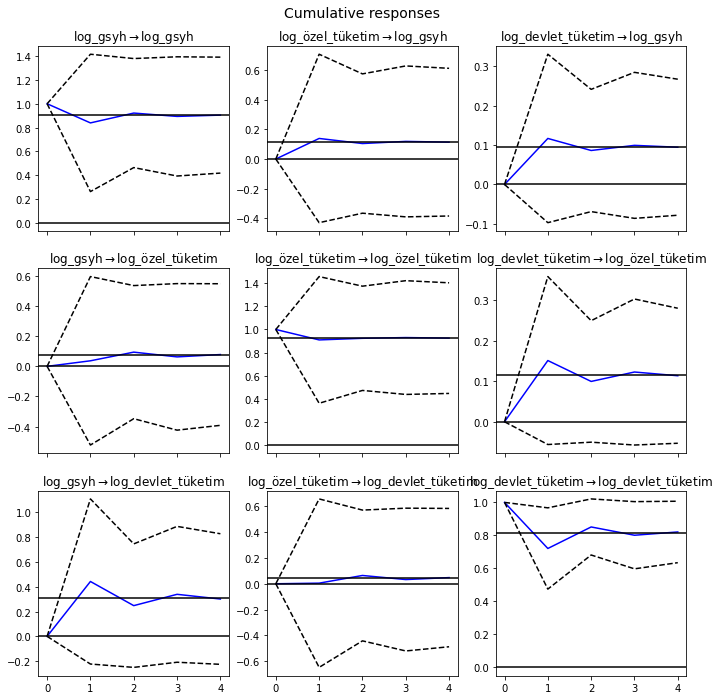

In [18]:
etki_tepki.plot_cum_effects(orth=False);

## 3.8. Öngörü Hatası Değişinti Ayrıştırması (Forecast Error Variance Decomposition-FEVD)


Değişinti ayrıştırma yolu ile, değişkenlerin birbirini etkileme dereceleri bulunmaktadır. Bir i-adım ileri öngörüde j bileşeninin k üzerindeki öngörü hataları, ortogonalleştirilmiş etki-tepkiler $\Theta_{i}$, kullanılarak ayrıştırılabilir:

$$
\begin{gathered}
\omega_{j k, i}=\sum_{i=0}^{h-1}\left(e_{j}^{\prime} \Theta_{i} e_{k}\right)^{2} / \operatorname{MSE}_{j}(h) \\
\operatorname{MSE}_{j}(h)=\sum_{i=0}^{h-1} e_{j}^{\prime} \Phi_{i} \Sigma_{u} \Phi_{i}^{\prime} e_{j}
\end{gathered}
$$

`fevd` metodunu burada hesaplama için kullanabiliriz:

In [19]:
değişinti_ayrıştırması = sonuçlar.fevd(4)
değişinti_ayrıştırması.summary()

FEVD for log_gsyh
     log_gsyh  log_özel_tüketim  log_devlet_tüketim
0    1.000000          0.000000            0.000000
1    0.985582          0.001029            0.013388
2    0.984642          0.001086            0.014273
3    0.984469          0.001095            0.014435

FEVD for log_özel_tüketim
     log_gsyh  log_özel_tüketim  log_devlet_tüketim
0    0.848238          0.151762            0.000000
1    0.825404          0.151090            0.023505
2    0.823303          0.150581            0.026117
3    0.822877          0.150473            0.026650

FEVD for log_devlet_tüketim
     log_gsyh  log_özel_tüketim  log_devlet_tüketim
0    0.227329          0.021838            0.750833
1    0.259599          0.021038            0.719363
2    0.259089          0.020734            0.720177
3    0.259270          0.020691            0.720039




Bunlar, `fevd` metoduna bağlı `plot` metodu ile görselleştirilebilir:

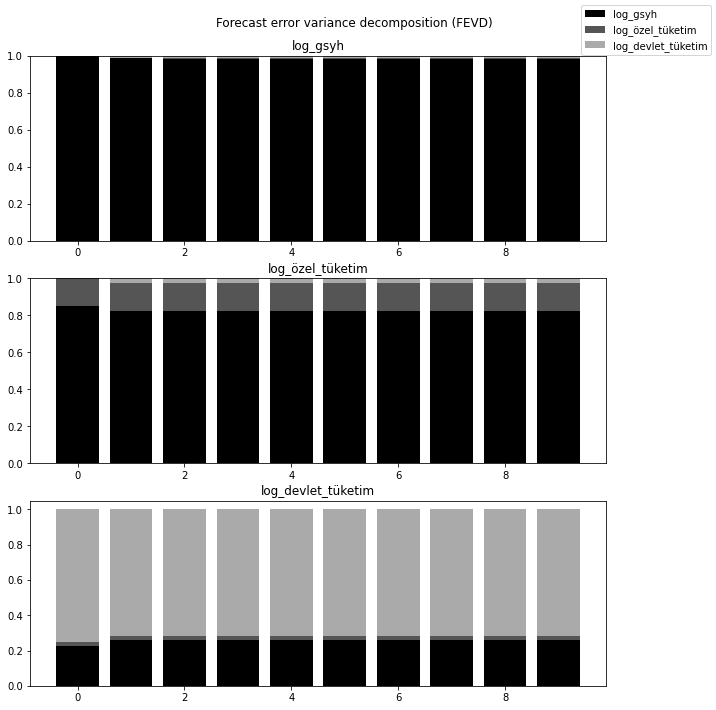

In [20]:
sonuçlar.fevd(10).plot();